# First Part : Import data

In [33]:
import scipy
import numpy
import sklearn
import pandas as pds
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as sch
from sklearn import tree
from sklearn import metrics

In [2]:
dt = pds.read_csv('569a01d3-3538-49da-a03a-63d8d3151235_Data.txt', sep="\t") # load a pandas dataframe from csv in current directory
dt = dt[:-5]
dt

,Time,Time Code,Country Name,Country Code,CO2 emissions (kg per 2011 PPP $ of GDP) [EN.ATM.CO2E.PP.GD.KD],Access to electricity (% of population) [EG.ELC.ACCS.ZS],"Electricity production from oil, gas and coal sources (% of total) [EG.ELC.FOSL.ZS]",GDP per capita growth (annual %) [NY.GDP.PCAP.KD.ZG],"Industry (including construction), value added per worker (constant 2010 US$) [NV.IND.EMPL.KD]","Agriculture, forestry, and fishing, value added per worker (constant 2010 US$) [NV.AGR.EMPL.KD]","International tourism, receipts (% of total exports) [ST.INT.RCPT.XP.ZS]",Exports of goods and services (% of GDP) [NE.EXP.GNFS.ZS],Imports of goods and services (% of GDP) [NE.IMP.GNFS.ZS],Urban population (% of total population) [SP.URB.TOTL.IN.ZS],"Population, total [SP.POP.TOTL]","Death rate, crude (per 1,000 people) [SP.DYN.CDRT.IN]",Forest area (% of land area) [AG.LND.FRST.ZS]
0,2014,YR2014,Afghanistan,AFG,0.163691,89.500000,NaN,-0.665271,2098.467820,1016.325617,6.091047,15.782377,51.413547,24.587,33370794.0,7.141,2.067825
1,2014,YR2014,Albania,ALB,0.184922,100.000000,0.000000,1.980930,15410.716379,5431.984311,49.514703,28.213001,47.194844,56.423,2889104.0,7.219,28.191972
2,2014,YR2014,Algeria,DZA,0.275704,99.877052,99.604620,1.699790,27123.281149,19022.535897,0.496957,30.219117,31.926659,70.221,38923687.0,4.709,0.818057
3,2014,YR2014,American Samoa,ASM,NaN,NaN,NaN,0.803753,NaN,NaN,NaN,66.251944,105.443235,87.288,55791.0,4.200,87.900000
4,2014,YR2014,Andorra,AND,NaN,100.000000,NaN,4.293204,NaN,NaN,NaN,NaN,NaN,88.441,79213.0,NaN,34.042553
5,2014,YR2014,Angola,AGO,0.189387,32.000000,46.824895,1.219833,57795.491981,1446.776745,2.624433,44.695031,34.637896,62.731,26941779.0,9.454,46.507420
6,2014,YR2014,Antigua and Barbuda,ATG,0.275901,100.000000,NaN,3.475435,NaN,NaN,78.264635,46.311657,58.216221,25.175,92562.0,6.188,22.272728
7,2014,YR2014,Argentina,ARG,0.252522,100.000000,64.257069,-3.578581,25174.695235,304184.964709,6.897874,14.405479,14.001315,91.377,42669500.0,7.651,10.015311
8,2014,YR2014,Armenia,ARM,0.238707,100.000000,42.438710,3.072859,NaN,NaN,29.954687,28.565139,47.046546,63.112,2912403.0,9.796,11.654373
9,2014,YR2014,Aruba,ABW,0.232496,100.000000,NaN,0.250567,NaN,NaN,70.663577,69.850306,79.759646,43.041,103774.0,8.488,2.333333


In [3]:
 stamps = ['Time\t', 'Time Code\t', 'Country Name\t', 'Country Code\t', 'CO2 emissions (kg per 2011 PPP $ of GDP)\t', 'Access to electricity (% of population)\t', 'Electricity production from oil, gas and coal sources (% of total)\t', 'GDP per capita growth (annual %)\t', 'Industry (including construction), value added per worker (constant 2010 US$)\t', 'Agriculture, forestry, and fishing, value added per worker (constant 2010 US$)\t', 'International tourism, receipts (% of total exports)\t', 'Exports of goods and services (% of GDP)\t', 'Imports of goods and services (% of GDP)\t', 'Urban population (% of total population)\t', 'Population, total\t', 'Death rate, crude (per 1,000 people)\t', 'Forest area (% of land area)']

In [4]:
dt.columns = stamps
dt

,Time,Time Code,Country Name,Country Code,CO2 emissions (kg per 2011 PPP $ of GDP),Access to electricity (% of population),"Electricity production from oil, gas and coal sources (% of total)",GDP per capita growth (annual %),"Industry (including construction), value added per worker (constant 2010 US$)","Agriculture, forestry, and fishing, value added per worker (constant 2010 US$)","International tourism, receipts (% of total exports)",Exports of goods and services (% of GDP),Imports of goods and services (% of GDP),Urban population (% of total population),"Population, total","Death rate, crude (per 1,000 people)",Forest area (% of land area)
0,2014,YR2014,Afghanistan,AFG,0.163691,89.500000,NaN,-0.665271,2098.467820,1016.325617,6.091047,15.782377,51.413547,24.587,33370794.0,7.141,2.067825
1,2014,YR2014,Albania,ALB,0.184922,100.000000,0.000000,1.980930,15410.716379,5431.984311,49.514703,28.213001,47.194844,56.423,2889104.0,7.219,28.191972
2,2014,YR2014,Algeria,DZA,0.275704,99.877052,99.604620,1.699790,27123.281149,19022.535897,0.496957,30.219117,31.926659,70.221,38923687.0,4.709,0.818057
3,2014,YR2014,American Samoa,ASM,NaN,NaN,NaN,0.803753,NaN,NaN,NaN,66.251944,105.443235,87.288,55791.0,4.200,87.900000
4,2014,YR2014,Andorra,AND,NaN,100.000000,NaN,4.293204,NaN,NaN,NaN,NaN,NaN,88.441,79213.0,NaN,34.042553
5,2014,YR2014,Angola,AGO,0.189387,32.000000,46.824895,1.219833,57795.491981,1446.776745,2.624433,44.695031,34.637896,62.731,26941779.0,9.454,46.507420
6,2014,YR2014,Antigua and Barbuda,ATG,0.275901,100.000000,NaN,3.475435,NaN,NaN,78.264635,46.311657,58.216221,25.175,92562.0,6.188,22.272728
7,2014,YR2014,Argentina,ARG,0.252522,100.000000,64.257069,-3.578581,25174.695235,304184.964709,6.897874,14.405479,14.001315,91.377,42669500.0,7.651,10.015311
8,2014,YR2014,Armenia,ARM,0.238707,100.000000,42.438710,3.072859,NaN,NaN,29.954687,28.565139,47.046546,63.112,2912403.0,9.796,11.654373
9,2014,YR2014,Aruba,ABW,0.232496,100.000000,NaN,0.250567,NaN,NaN,70.663577,69.850306,79.759646,43.041,103774.0,8.488,2.333333


In [5]:
dt.index = dt['Country Name\t']
dt

,Time,Time Code,Country Name,Country Code,CO2 emissions (kg per 2011 PPP $ of GDP),Access to electricity (% of population),"Electricity production from oil, gas and coal sources (% of total)",GDP per capita growth (annual %),"Industry (including construction), value added per worker (constant 2010 US$)","Agriculture, forestry, and fishing, value added per worker (constant 2010 US$)","International tourism, receipts (% of total exports)",Exports of goods and services (% of GDP),Imports of goods and services (% of GDP),Urban population (% of total population),"Population, total","Death rate, crude (per 1,000 people)",Forest area (% of land area)
Country Name,,,,,,,,,,,,,,,,,
Afghanistan,2014,YR2014,Afghanistan,AFG,0.163691,89.500000,NaN,-0.665271,2098.467820,1016.325617,6.091047,15.782377,51.413547,24.587,33370794.0,7.141,2.067825
Albania,2014,YR2014,Albania,ALB,0.184922,100.000000,0.000000,1.980930,15410.716379,5431.984311,49.514703,28.213001,47.194844,56.423,2889104.0,7.219,28.191972
Algeria,2014,YR2014,Algeria,DZA,0.275704,99.877052,99.604620,1.699790,27123.281149,19022.535897,0.496957,30.219117,31.926659,70.221,38923687.0,4.709,0.818057
American Samoa,2014,YR2014,American Samoa,ASM,NaN,NaN,NaN,0.803753,NaN,NaN,NaN,66.251944,105.443235,87.288,55791.0,4.200,87.900000
Andorra,2014,YR2014,Andorra,AND,NaN,100.000000,NaN,4.293204,NaN,NaN,NaN,NaN,NaN,88.441,79213.0,NaN,34.042553
Angola,2014,YR2014,Angola,AGO,0.189387,32.000000,46.824895,1.219833,57795.491981,1446.776745,2.624433,44.695031,34.637896,62.731,26941779.0,9.454,46.507420
Antigua and Barbuda,2014,YR2014,Antigua and Barbuda,ATG,0.275901,100.000000,NaN,3.475435,NaN,NaN,78.264635,46.311657,58.216221,25.175,92562.0,6.188,22.272728
Argentina,2014,YR2014,Argentina,ARG,0.252522,100.000000,64.257069,-3.578581,25174.695235,304184.964709,6.897874,14.405479,14.001315,91.377,42669500.0,7.651,10.015311
Armenia,2014,YR2014,Armenia,ARM,0.238707,100.000000,42.438710,3.072859,NaN,NaN,29.954687,28.565139,47.046546,63.112,2912403.0,9.796,11.654373


In [6]:
dt = dt.drop(['Time\t', 'Time Code\t', 'Country Name\t', 'Country Code\t'], axis=1)
dt

,CO2 emissions (kg per 2011 PPP $ of GDP),Access to electricity (% of population),"Electricity production from oil, gas and coal sources (% of total)",GDP per capita growth (annual %),"Industry (including construction), value added per worker (constant 2010 US$)","Agriculture, forestry, and fishing, value added per worker (constant 2010 US$)","International tourism, receipts (% of total exports)",Exports of goods and services (% of GDP),Imports of goods and services (% of GDP),Urban population (% of total population),"Population, total","Death rate, crude (per 1,000 people)",Forest area (% of land area)
Country Name,,,,,,,,,,,,,
Afghanistan,0.163691,89.500000,NaN,-0.665271,2098.467820,1016.325617,6.091047,15.782377,51.413547,24.587,33370794.0,7.141,2.067825
Albania,0.184922,100.000000,0.000000,1.980930,15410.716379,5431.984311,49.514703,28.213001,47.194844,56.423,2889104.0,7.219,28.191972
Algeria,0.275704,99.877052,99.604620,1.699790,27123.281149,19022.535897,0.496957,30.219117,31.926659,70.221,38923687.0,4.709,0.818057
American Samoa,NaN,NaN,NaN,0.803753,NaN,NaN,NaN,66.251944,105.443235,87.288,55791.0,4.200,87.900000
Andorra,NaN,100.000000,NaN,4.293204,NaN,NaN,NaN,NaN,NaN,88.441,79213.0,NaN,34.042553
Angola,0.189387,32.000000,46.824895,1.219833,57795.491981,1446.776745,2.624433,44.695031,34.637896,62.731,26941779.0,9.454,46.507420
Antigua and Barbuda,0.275901,100.000000,NaN,3.475435,NaN,NaN,78.264635,46.311657,58.216221,25.175,92562.0,6.188,22.272728
Argentina,0.252522,100.000000,64.257069,-3.578581,25174.695235,304184.964709,6.897874,14.405479,14.001315,91.377,42669500.0,7.651,10.015311
Armenia,0.238707,100.000000,42.438710,3.072859,NaN,NaN,29.954687,28.565139,47.046546,63.112,2912403.0,9.796,11.654373


In [7]:
dt = dt.dropna()

In [8]:
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt

In [9]:
dt

,CO2 emissions (kg per 2011 PPP $ of GDP),Access to electricity (% of population),"Electricity production from oil, gas and coal sources (% of total)",GDP per capita growth (annual %),"Industry (including construction), value added per worker (constant 2010 US$)","Agriculture, forestry, and fishing, value added per worker (constant 2010 US$)","International tourism, receipts (% of total exports)",Exports of goods and services (% of GDP),Imports of goods and services (% of GDP),Urban population (% of total population),"Population, total","Death rate, crude (per 1,000 people)",Forest area (% of land area)
Country Name,,,,,,,,,,,,,
Albania,0.184922,100.000000,0.000000,1.980930,15410.716379,5431.984311,49.514703,28.213001,47.194844,56.423,2.889104e+06,7.219,28.191972
Algeria,0.275704,99.877052,99.604620,1.699790,27123.281149,19022.535897,0.496957,30.219117,31.926659,70.221,3.892369e+07,4.709,0.818057
Angola,0.189387,32.000000,46.824895,1.219833,57795.491981,1446.776745,2.624433,44.695031,34.637896,62.731,2.694178e+07,9.454,46.507420
Argentina,0.252522,100.000000,64.257069,-3.578581,25174.695235,304184.964709,6.897874,14.405479,14.001315,91.377,4.266950e+07,7.651,10.015311
Australia,0.352370,100.000000,85.093288,1.050180,134038.446027,81470.411093,11.312784,21.039455,21.467035,85.602,2.347569e+07,6.600,16.198664
Austria,0.155262,100.000000,17.721046,-0.122369,99415.945631,26056.410587,8.857949,53.386579,50.116956,57.526,8.546356e+06,9.200,46.862087
Azerbaijan,0.233278,100.000000,94.018926,1.522139,47844.821994,2018.483911,8.333124,43.273557,26.209669,54.422,9.535079e+06,5.800,13.466485
Bahrain,0.534926,100.000000,100.000000,2.706112,50062.321981,10912.131122,5.965235,96.050751,79.513899,88.915,1.336075e+06,2.337,0.765240
Bangladesh,0.154435,62.400000,98.680276,4.856108,3571.749175,869.204249,0.465859,18.989660,25.524420,33.535,1.545202e+08,5.565,10.997926


## Corrélation

In [10]:
dt.corr()

,CO2 emissions (kg per 2011 PPP $ of GDP),Access to electricity (% of population),"Electricity production from oil, gas and coal sources (% of total)",GDP per capita growth (annual %),"Industry (including construction), value added per worker (constant 2010 US$)","Agriculture, forestry, and fishing, value added per worker (constant 2010 US$)","International tourism, receipts (% of total exports)",Exports of goods and services (% of GDP),Imports of goods and services (% of GDP),Urban population (% of total population),"Population, total","Death rate, crude (per 1,000 people)",Forest area (% of land area)
CO2 emissions (kg per 2011 PPP $ of GDP)\t,1.000000,0.274127,0.359183,-0.212124,-0.062150,-0.034418,-0.119785,0.056523,0.062583,0.135239,0.188129,0.048870,-0.191606
Access to electricity (% of population)\t,0.274127,1.000000,0.128100,-0.329176,0.338958,0.284109,0.014577,0.227089,0.094740,0.591564,0.006627,-0.093364,-0.044663
"Electricity production from oil, gas and coal sources (% of total)\t",0.359183,0.128100,1.000000,-0.127472,-0.015526,-0.087164,-0.073331,0.126655,0.015889,0.136812,0.122155,-0.215226,-0.302908
GDP per capita growth (annual %)\t,-0.212124,-0.329176,-0.127472,1.000000,-0.337297,-0.356535,0.021202,0.013233,0.131582,-0.520827,0.231039,0.127288,0.075547
"Industry (including construction), value added per worker (constant 2010 US$)\t",-0.062150,0.338958,-0.015526,-0.337297,1.000000,0.508513,-0.288006,0.425712,0.156820,0.581236,-0.101712,-0.148391,0.040373
"Agriculture, forestry, and fishing, value added per worker (constant 2010 US$)\t",-0.034418,0.284109,-0.087164,-0.356535,0.508513,1.000000,-0.128625,0.014033,-0.133903,0.480087,-0.061797,-0.008702,-0.027021
"International tourism, receipts (% of total exports)\t",-0.119785,0.014577,-0.073331,0.021202,-0.288006,-0.128625,1.000000,-0.205395,0.030890,-0.195178,-0.146200,-0.061157,-0.077567
Exports of goods and services (% of GDP)\t,0.056523,0.227089,0.126655,0.013233,0.425712,0.014033,-0.205395,1.000000,0.877228,0.307424,-0.183773,-0.003058,0.051499
Imports of goods and services (% of GDP)\t,0.062583,0.094740,0.015889,0.131582,0.156820,-0.133903,0.030890,0.877228,1.000000,0.082909,-0.234622,0.058794,0.005540
Urban population (% of total population)\t,0.135239,0.591564,0.136812,-0.520827,0.581236,0.480087,-0.195178,0.307424,0.082909,1.000000,-0.143020,-0.115397,0.030171


In [11]:
dt = dt.drop(['Imports of goods and services (% of GDP)\t', 'Population, total\t', 'Urban population (% of total population)\t', 'Agriculture, forestry, and fishing, value added per worker (constant 2010 US$)\t', 'International tourism, receipts (% of total exports)\t', 'Industry (including construction), value added per worker (constant 2010 US$)\t', 'Electricity production from oil, gas and coal sources (% of total)\t'], axis=1)
dt

,CO2 emissions (kg per 2011 PPP $ of GDP),Access to electricity (% of population),GDP per capita growth (annual %),Exports of goods and services (% of GDP),"Death rate, crude (per 1,000 people)",Forest area (% of land area)
Country Name,,,,,,
Albania,0.184922,100.000000,1.980930,28.213001,7.219,28.191972
Algeria,0.275704,99.877052,1.699790,30.219117,4.709,0.818057
Angola,0.189387,32.000000,1.219833,44.695031,9.454,46.507420
Argentina,0.252522,100.000000,-3.578581,14.405479,7.651,10.015311
Australia,0.352370,100.000000,1.050180,21.039455,6.600,16.198664
Austria,0.155262,100.000000,-0.122369,53.386579,9.200,46.862087
Azerbaijan,0.233278,100.000000,1.522139,43.273557,5.800,13.466485
Bahrain,0.534926,100.000000,2.706112,96.050751,2.337,0.765240
Bangladesh,0.154435,62.400000,4.856108,18.989660,5.565,10.997926


In [12]:
dt.corr()

,CO2 emissions (kg per 2011 PPP $ of GDP),Access to electricity (% of population),GDP per capita growth (annual %),Exports of goods and services (% of GDP),"Death rate, crude (per 1,000 people)",Forest area (% of land area)
CO2 emissions (kg per 2011 PPP $ of GDP)\t,1.000000,0.274127,-0.212124,0.056523,0.048870,-0.191606
Access to electricity (% of population)\t,0.274127,1.000000,-0.329176,0.227089,-0.093364,-0.044663
GDP per capita growth (annual %)\t,-0.212124,-0.329176,1.000000,0.013233,0.127288,0.075547
Exports of goods and services (% of GDP)\t,0.056523,0.227089,0.013233,1.000000,-0.003058,0.051499
"Death rate, crude (per 1,000 people)\t",0.048870,-0.093364,0.127288,-0.003058,1.000000,0.194420
Forest area (% of land area),-0.191606,-0.044663,0.075547,0.051499,0.194420,1.000000


## SSE

In [13]:
sse_list = []
k_list = range(2,11)
for i in k_list:
    km_i_clusters=KMeans(n_clusters=i)
    km_i_clusters.fit(dt)
    sse_list = sse_list + [km_i_clusters.inertia_]
print(sse_list)

[157738.81634928158, 105474.84153336225, 76718.8361603927, 57647.18008663467, 48325.829752996724, 40311.18660198631, 35513.89892337281, 32290.225152393556, 27942.821938352994]


Text(0,0.5,'SSE')

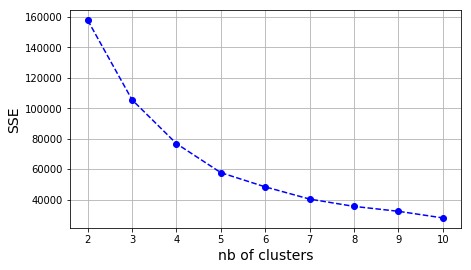

In [14]:
fig = plt.figure(figsize=(7, 4))
plt.plot(k_list,sse_list,'bo--')
plt.grid()
plt.xlabel("nb of clusters",fontsize=14)
plt.ylabel("SSE",fontsize=14)

## K-Means

In [15]:
km = KMeans(n_clusters = 3) # create a KMeans object
km.fit(dt) # compute the clusters

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

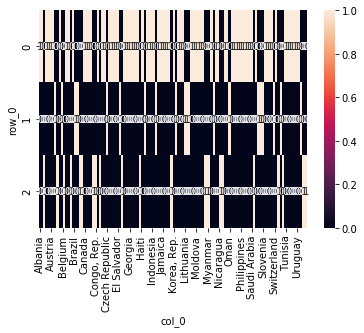

In [16]:
km.cluster_centers_
clusters = km.labels_ # get cluster labels for all objects
crosstab = pds.crosstab(clusters, dt.index)
sns.heatmap(crosstab, annot=True)

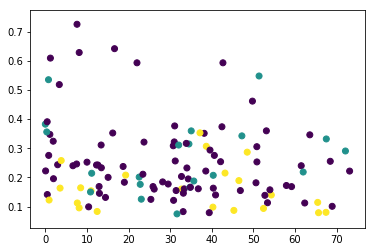

In [17]:
plt.scatter(dt.iloc[:,5], dt.iloc[:,0], c = clusters)

In [18]:
# sns.pairplot(data=dt, hue="clusters")

c1  = []
c2  = []
c3  = []
#c4  = []
dt.index[1]
lab = km.labels_
for i in range(len(lab)) :
    if lab[i] == 0 :
        c1.append(dt.index[i])
    elif lab[i] == 1 :
        c2.append(dt.index[i])
    else :
        c3.append(dt.index[i])
print(c1)
print(c2)
print(c3)
#print(c4)

['Albania', 'Algeria', 'Argentina', 'Australia', 'Austria', 'Azerbaijan', 'Belarus', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Canada', 'Chile', 'China', 'Colombia', 'Costa Rica', 'Croatia', 'Cyprus', 'Denmark', 'Dominican Republic', 'Ecuador', 'Egypt, Arab Rep.', 'El Salvador', 'Finland', 'France', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Honduras', 'Iceland', 'India', 'Indonesia', 'Iraq', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Korea, Rep.', 'Kyrgyz Republic', 'Latvia', 'Lebanon', 'Mauritius', 'Mexico', 'Moldova', 'Mongolia', 'Montenegro', 'Morocco', 'Nepal', 'New Zealand', 'Nicaragua', 'North Macedonia', 'Norway', 'Pakistan', 'Panama', 'Paraguay', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Romania', 'Russian Federation', 'Saudi Arabia', 'Serbia', 'South Africa', 'Spain', 'Sri Lanka', 'Sweden', 'Tajikistan', 'Tunisia', 'Turkey', 'Ukraine', 'United Kingdom', 'United States', 'Uruguay', 'Venezuela, RB']
['Bahrain', 'Belgium', 'Brunei Darus

In [19]:
dt.index[1]

'Algeria'

In [20]:
km.labels_[1]

0

## Hierarchical clustering

Le clustering hierarchique peut être agglomeratif ou divisif, deux types qui ne se diffèrent que par le sens de regroupement. Le clustering hierarchique agglomeratif que l'on va utiliser part de tous les points et les regroupe en $n$ clusters cependant le nombre $n$ diminue jusqu'à $1$. On peut alors choisir le nombre de clusters a posteriori. Le regroupement se fait grâce à une fonction de distance donnée lors de l'appel.

Tout d'abord, on appelle une fonction qui calcule l'arbre d'aggrégation et on dessine le dendrogramme associé.

In [21]:
agg = sch.linkage(dt, method='complete', metric='euclidean')

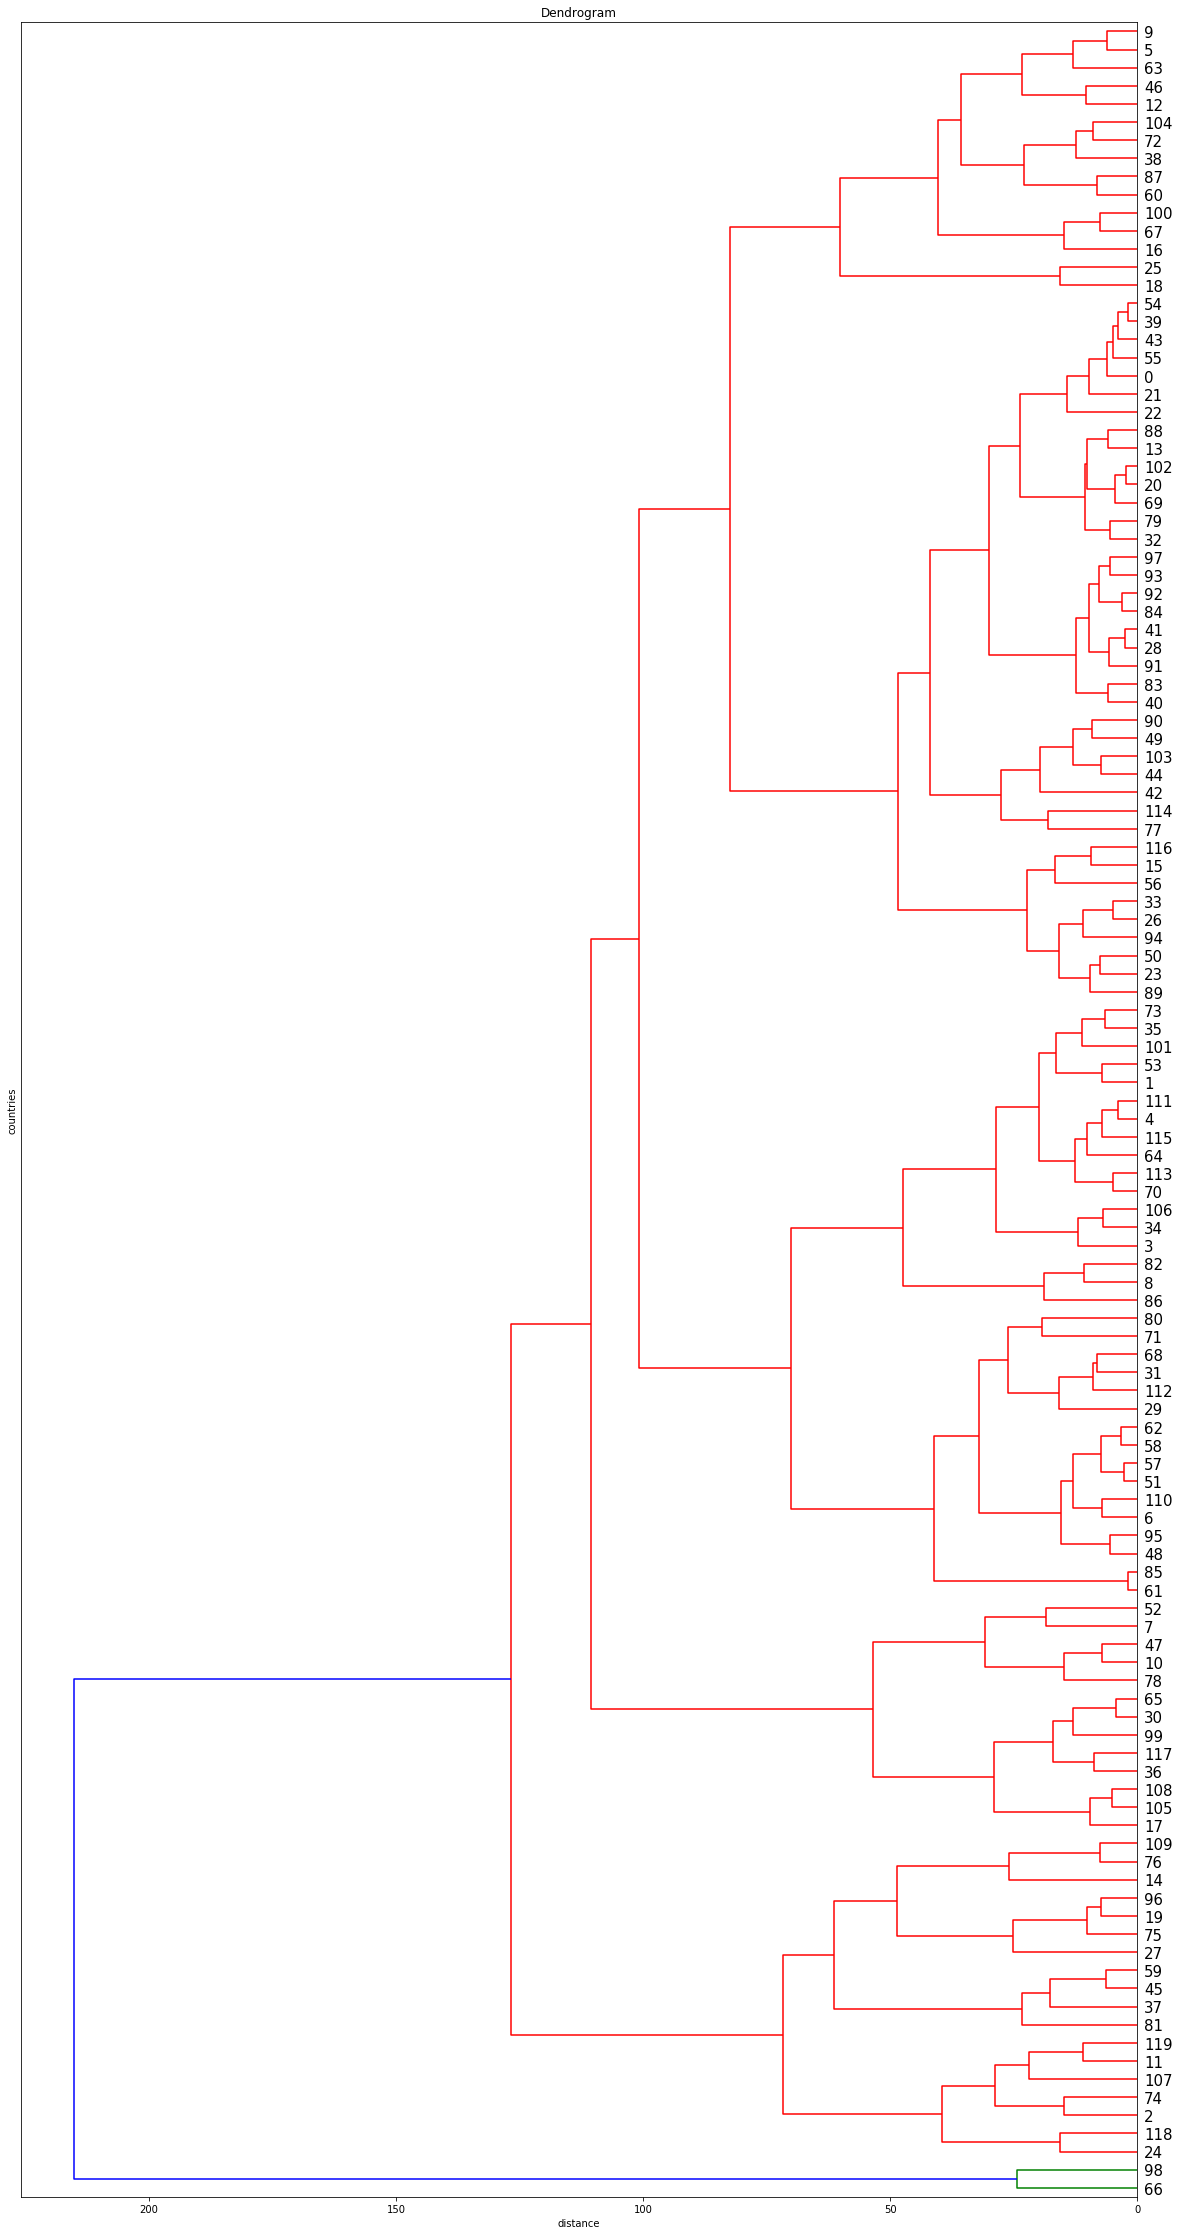

In [22]:
fig = plt.figure(figsize=(20, 40))
dendro = sch.dendrogram(agg, orientation='left', leaf_rotation=0, leaf_font_size=15)
# in blue: nodes with a merging distance >= 0.7 * maximal merging distance

plt.title('Dendrogram')
plt.ylabel('countries')
plt.xlabel('distance');

Ce dendrogramme est plutôt pas clair, on ne va se alors limiter qu'à la zone qui nous intéresse, c'est-à-dire les $6$ derniers clusters et moins.

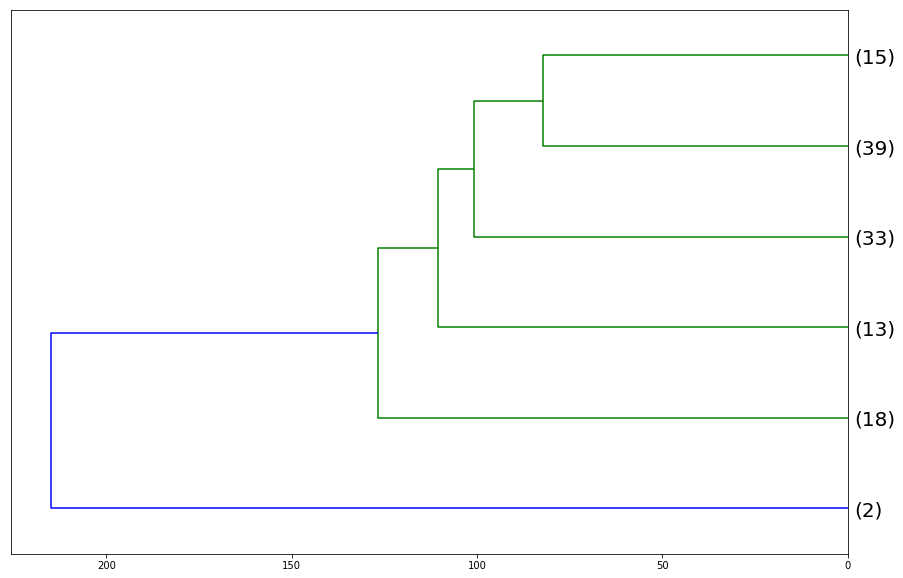

In [23]:
fig = plt.figure(figsize=(15, 10))
dendro = sch.dendrogram(agg, orientation='left', p=6, truncate_mode='lastp',
                        show_leaf_counts=True, leaf_rotation=0, leaf_font_size=20)

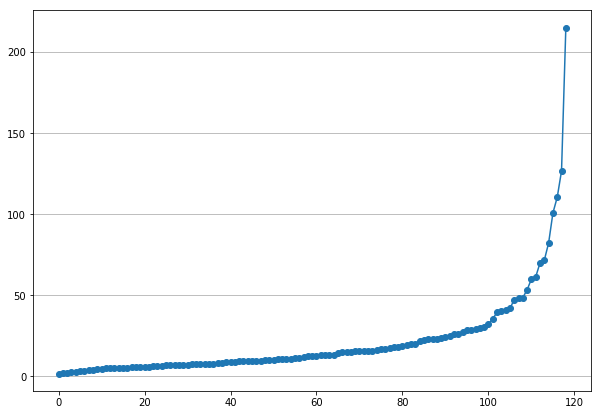

In [24]:
fig = plt.figure(figsize=(10, 7))
plt.plot(agg[:,2],'o-')
plt.grid(axis='y')

La courbe de la distance de regroupement nous montre la similaritude entre les clusters fusionnés à chaque étape. 

On regarde que l'un des 2 clusters principaux est composé seulement des deux pays. On est donc assez suspects - ces deux pays pourraient facilement être des outliers. On les affiche - effectivement, il s'agit de Luxembourg et Singapore. On les enlève de notre jeu de données.

In [25]:
nb_clust = 2
clusters = sch.fcluster(agg, nb_clust, criterion='maxclust')
c2  = []
lab = km.labels_
for i in range(len(clusters)) :
    if clusters[i] == 1 :
        c2.append(dt.index[i])
print(c2)

dt = dt.drop(['Luxembourg', 'Singapore'], axis=0)

['Luxembourg', 'Singapore']


On va étudier l'influence de la fonction de distance. On utilise les méthodes *complete, average et ward* pour les mesures *euclidienne, manhattan*. La distance de Ward n!est pas appliquable dans le cas de mesure *manhattan*.

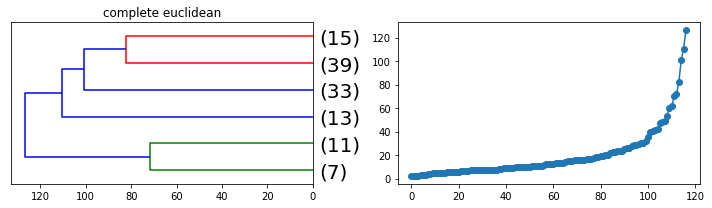

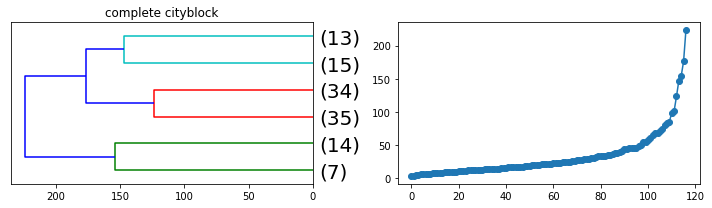

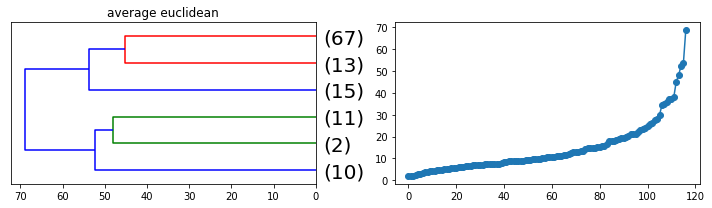

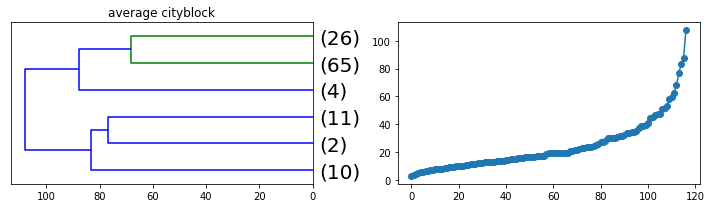

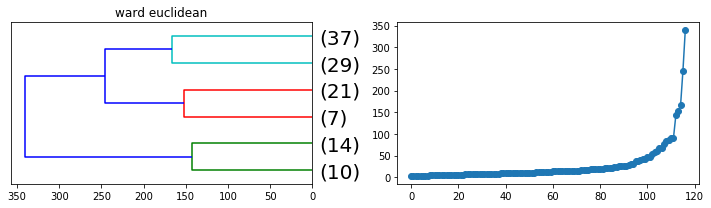

In [30]:
methods = ["complete", "average", "ward"]
metric = ["euclidean","cityblock"]

dendros = {}
plots = {}
p = True
for d in methods:
    for c in metric:
        if d!= 'ward':
            agg = sch.linkage(dt, method=d, metric=c)
        elif p:
            agg = sch.linkage(dt, method=d, metric='euclidean')
            p = False
        else:
            break
        fig = plt.figure(figsize=(10, 3))
        plt.subplot(1, 2, 1)
        plt.title(d + ' ' + c)
        dendros[d+"-"+c] = sch.dendrogram(agg, orientation='left', p=6, truncate_mode='lastp',
                        show_leaf_counts=True, leaf_rotation=0, leaf_font_size=20)
        plt.subplot(1, 2, 2)
        plots[d+"-"+c] = plt.plot(agg[:,2],'o-')
        plt.tight_layout()

Intérpretation et résultat - quelle est la meilleure?

In [27]:
nb_clust = 4
clusters = sch.fcluster(agg, nb_clust, criterion='maxclust')
print(clusters)
c1  = []
c2  = []
c3  = []
c4  = []
lab = km.labels_
for i in range(len(clusters)) :
    if clusters[i] == 1 :
        c1.append(dt.index[i])
    elif clusters[i] == 2 :
        c2.append(dt.index[i])
    elif clusters[i] == 3 :
        c3.append(dt.index[i])
    else :
        c4.append(dt.index[i])
print(c1)
print(c2)
print(c3)
print(c4)

[4 3 1 3 3 2 3 2 1 2 2 1 2 4 1 4 2 2 1 1 4 4 3 4 1 1 4 1 4 3 2 3 4 4 3 3 2
 1 2 4 4 4 1 4 4 1 2 2 3 4 4 3 2 3 4 4 4 3 3 1 2 2 3 2 3 2 2 3 4 3 3 2 3 1
 1 1 4 2 4 3 1 1 4 4 2 1 2 4 4 4 4 4 4 4 3 1 4 2 2 3 4 4 2 2 3 1 2 1 3 3 3
 3 4 3 4 2 1 1]
['Angola', 'Bangladesh', 'Benin', 'Botswana', 'Cambodia', 'Cameroon', 'Congo, Dem. Rep.', 'Congo, Rep.', "Cote d'Ivoire", 'Ethiopia', 'Ghana', 'Haiti', 'Kenya', 'Mozambique', 'Myanmar', 'Namibia', 'Niger', 'Nigeria', 'Pakistan', 'Senegal', 'Tanzania', 'Togo', 'Zambia', 'Zimbabwe']
['Austria', 'Bahrain', 'Belarus', 'Belgium', 'Bolivia', 'Brunei Darussalam', 'Bulgaria', 'Czech Republic', 'Estonia', 'Finland', 'Honduras', 'Hungary', 'Ireland', 'Korea, Rep.', 'Kuwait', 'Latvia', 'Lithuania', 'Malaysia', 'Montenegro', 'Netherlands', 'Oman', 'Panama', 'Slovak Republic', 'Slovenia', 'Sweden', 'Switzerland', 'Thailand', 'Vietnam']
['Algeria', 'Argentina', 'Australia', 'Azerbaijan', 'China', 'Cyprus', 'Denmark', 'Egypt, Arab Rep.', 'El Salvador', 'Iceland', 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


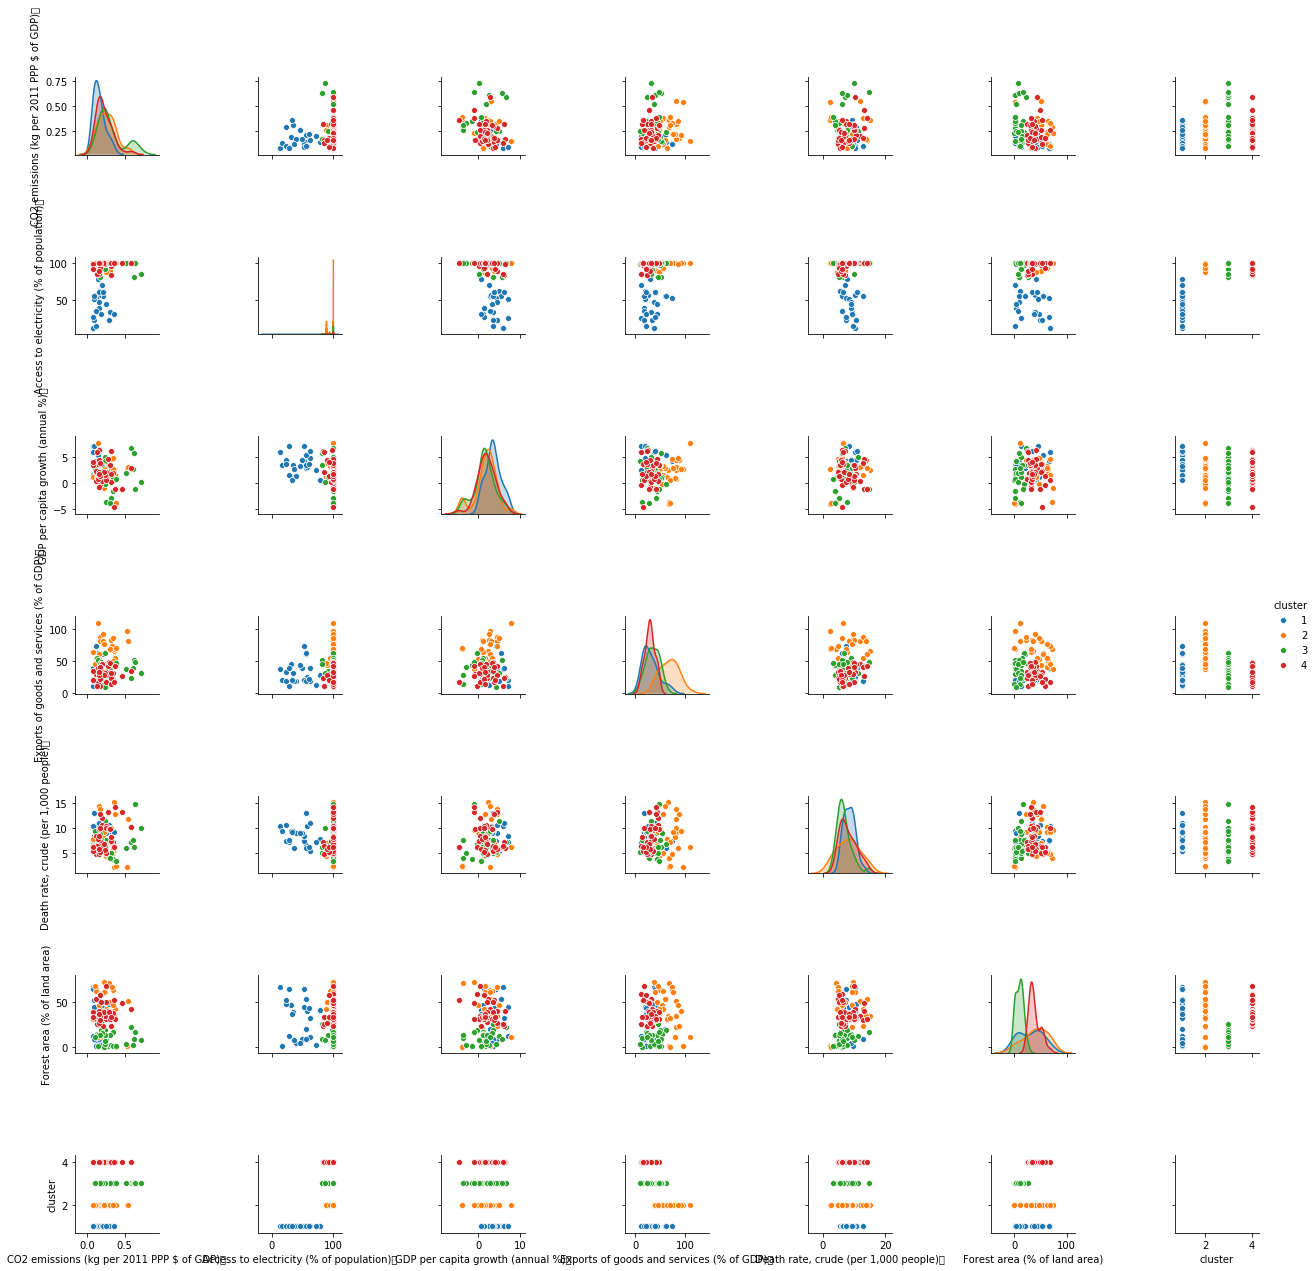

In [28]:
df_all = dt.copy()
df_all['cluster']= clusters
sns.pairplot(data=df_all,hue='cluster')

In [34]:
metrics.silhouette_score(dt.values, clusters, metric='euclidean', sample_size=None)

0.2898543121429699

Silhouette intérpretation.